# Mobile Phone Price Prediction using Machine Learning

## Step 1: Importing Required Libraries and Models


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.decomposition import PCA

## Step 2: Data Collection

In [28]:
data = pd.read_csv('Mobiles-Dataset-2025.csv', encoding='latin1')
data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024


In [21]:
# data = data[['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)']]
data.shape

(930, 15)

## Step 3: Data Preprocessing

In [ ]:
# Check for null value
data.isnull().sum()

,0
Company Name,0
Model Name,0
Mobile Weight,0
RAM,0
Front Camera,0
Back Camera,0
Processor,0
Battery Capacity,0
Screen Size,0
Launched Price (Pakistan),0


In [29]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
# Giả định data đã được load thành công

# --- 1. ĐỊNH NGHĨA CÁC HÀM LÀM SẠCH ---

def clean_unit_columns(value):
    """Làm sạch các đơn vị và dấu phẩy, sau đó chuyển sang float."""
    if isinstance(value, str):
        value = value.replace('g', '').replace('mAh', '').replace('inches', '').replace(',', '').strip()
    try:
        return float(value)
    except:
        return np.nan

def clean_ram_camera_final(value):
    """Làm sạch các cột RAM, Camera (lấy số đầu tiên)."""
    value = str(value).upper()
    if '+' in value:
        value = value.split('+')[0].strip()

    cleaned_value = re.sub(r'[A-Z\s]', '', value)

    try:
        match = re.search(r'(\d+\.?\d*)', cleaned_value)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

def extract_rom(model_name):
    """Trích xuất giá trị ROM từ Model Name và chuẩn hóa về TB."""
    model_name = str(model_name).upper()
    match_tb = re.search(r'(\d+\.?\d*)TB', model_name)
    if match_tb:
        return float(match_tb.group(1))
    match_gb = re.search(r'(\d+\.?\d*)GB', model_name)
    if match_gb:
        return float(match_gb.group(1)) / 1024
    return np.nan

def clean_usa_price(price_str):
    """Làm sạch giá Launched Price (USA) với logic lọc giá trị hợp lệ."""
    if pd.isna(price_str):
        return np.nan

    price_str = str(price_str).strip()
    parts = re.findall(r'(\d+[\s,\.\d]*)', price_str)
    if parts:
        price_str = parts[0]
    else:
        price_str = price_str.replace("USD", "").replace("$", "").replace(",", "").replace(" ", "").strip()

    if price_str in ["", "Not available", "not available", "N/A", "None"]:
        return np.nan

    price_str = price_str.replace("USD", "").replace("$", "").replace(",", "").replace(" ", "").strip()

    try:
        value = float(price_str)
        if 99 <= value <= 2000:
            return value
        else:
            return np.nan
    except:
        return np.nan

# --- 2. ÁP DỤNG LÀM SẠCH DỮ LIỆU ĐẦU VÀO VÀ ĐIỀN THIẾU CỘT TÍNH NĂNG SỐ ---

print("Columns:", data.columns.tolist())

# Áp dụng hàm làm sạch
data['Battery Capacity'] = data['Battery Capacity'].apply(clean_unit_columns)
data['Screen Size'] = data['Screen Size'].apply(clean_unit_columns)

for col in ['RAM', 'Front Camera', 'Back Camera']:
    data[col] = data[col].apply(clean_ram_camera_final)

# ÁP DỤNG HÀM LÀM SẠCH GIÁ
data["Launched Price (USA)"] = data["Launched Price (USA)"].apply(clean_usa_price)

# Chuẩn hóa Pin
data['Battery Capacity'] = data['Battery Capacity'].apply(lambda x: x / 1000 if not pd.isna(x) else np.nan)

# Xử lý ROM
data['ROM'] = data['Model Name'].apply(extract_rom).apply(lambda x: x if not pd.isna(x) else np.nan)
data['ROM'] = data['ROM'].astype('Float64')
data['ROM'] = data['ROM'].fillna(data['ROM'].median())
print("ROM Median:", data['ROM'].median())

# >>> BƯỚC SỬA 1: ĐIỀN THIẾU CHO CỘT TÍNH NĂNG 'Screen Size' <<<
# Tính trung vị (median) của Screen Size
screen_median = data['Screen Size'].median()
data['Screen Size'] = data['Screen Size'].fillna(screen_median)
print(f"Điền thiếu Screen Size bằng trung vị: {screen_median:.2f}")


# --- 3. XỬ LÝ CỘT COMPANY NAME (ONE-HOT ENCODING) ---
if 'Company Name' in data.columns:
    company_counts = data['Company Name'].value_counts()
    top_companies = company_counts.head(5).index
    data['Company Simplified'] = data['Company Name'].apply(lambda x: x if x in top_companies else 'Other')
    data = pd.get_dummies(data, columns=['Company Simplified'], prefix='Company', drop_first=False, dtype=int)


# --- 4. TẠO ĐẶC TRƯNG GIÁ CHIP MỚI VÀ ĐIỀN THIẾU ---

if 'Processor' in data.columns:
    df_price_processor = data.dropna(subset=['Launched Price (USA)', 'Processor']).copy()

    processor_mean_price = df_price_processor.groupby('Processor')['Launched Price (USA)'].mean().reset_index()
    processor_mean_price.rename(columns={'Launched Price (USA)': 'Processor_Avg_Price'}, inplace=True)

    # Chuẩn hóa giá trị trung bình (Chia cho 100)
    processor_mean_price['Processor_Avg_Price_Scaled'] = processor_mean_price['Processor_Avg_Price'] / 100

    data = data.merge(processor_mean_price[['Processor', 'Processor_Avg_Price_Scaled']],
                      on='Processor',
                      how='left')

    # >>> BƯỚC SỬA 2: ĐIỀN THIẾU CHO CỘT TÍNH NĂNG 'Processor_Avg_Price_Scaled' <<<
    # Tính trung vị của Processor_Avg_Price_Scaled
    processor_scaled_median = data['Processor_Avg_Price_Scaled'].median()
    data['Processor_Avg_Price_Scaled'] = data['Processor_Avg_Price_Scaled'].fillna(processor_scaled_median)
    print(f"Điền thiếu Processor_Avg_Price_Scaled bằng trung vị: {processor_scaled_median:.2f}")


# --- 5. LOẠI BỎ CÁC CỘT CUỐI CÙNG VÀ CÁC HÀNG NaN CỦA BIẾN MỤC TIÊU ---

# Loại bỏ các cột không cần thiết
columns_to_drop_final = [
    'Company Name', 'Model Name', 'Mobile Weight', 'Processor', 'Launched Year',
    'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)',
    'Launched Price (Dubai)', 'Company Simplified',
    'Processor_vec1', 'Processor_vec2', 'Processor_vec3', 'Processor_Avg_Price'
]

data.drop(columns=[col for col in columns_to_drop_final if col in data.columns], inplace=True)

# >>> BƯỚC SỬA 3: LOẠI BỎ HÀNG THIẾU CỦA BIẾN MỤC TIÊU (Launched Price (USA)) <<<
data.dropna(subset=['Launched Price (USA)'], inplace=True)


# --- IN KẾT QUẢ XÁC NHẬN ---
print("\n✅ Xử lý NaN và Tinh gọn DataFrame hoàn tất!")
print("\nCác cột đã được loại bỏ:")
print(f"- Các cột văn bản/giá thừa đã được loại bỏ.")

print("\nKích thước DataFrame cuối cùng (sau khi loại bỏ NaN của biến mục tiêu):", data.shape)
print("\nKiểm tra NaN trong các cột đã sửa (Screen Size, Processor_Avg_Price_Scaled):")
print(data[['Screen Size', 'Processor_Avg_Price_Scaled', 'Launched Price (USA)']].isna().sum())

Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (Pakistan)', 'Launched Price (India)', 'Launched Price (China)', 'Launched Price (USA)', 'Launched Price (Dubai)', 'Launched Year']
ROM Median: 0.125
Điền thiếu Screen Size bằng trung vị: 6.67
Điền thiếu Processor_Avg_Price_Scaled bằng trung vị: 4.37

✅ Xử lý NaN và Tinh gọn DataFrame hoàn tất!

Các cột đã được loại bỏ:
- Các cột văn bản/giá thừa đã được loại bỏ.

Kích thước DataFrame cuối cùng (sau khi loại bỏ NaN của biến mục tiêu): (919, 14)

Kiểm tra NaN trong các cột đã sửa (Screen Size, Processor_Avg_Price_Scaled):
Screen Size                   0
Processor_Avg_Price_Scaled    0
Launched Price (USA)          0
dtype: int64


In [ ]:
data.describe()

,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,...,Company_Other,Company_Samsung,Company_Vivo,Processor_Avg_Price_Scaled,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo
count,915.000000,915.000000,915.000000,915.000000,907.000000,904.000000,915.000000,915.0,915.000000,915.000000,...,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,7.789071,18.166776,46.491585,0.000005,7.091786,575.522854,2022.205464,0.194723,0.106011,0.099454,...,0.478689,0.096175,0.093989,6.308169,0.106011,0.099454,0.125683,0.478689,0.096175,0.093989
std,3.191515,12.043474,31.124175,0.000001,1.550516,386.388978,1.869182,0.142852,0.308020,0.299434,...,0.499819,0.294992,0.291973,9.742648,0.308020,0.299434,0.331673,0.499819,0.294992,0.291973
min,1.000000,2.000000,5.000000,0.000002,5.000000,99.000000,2014.000000,0.015625,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.890000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,8.000000,13.000000,0.000004,6.500000,269.000000,2021.000000,0.125,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,16.000000,50.000000,0.000005,6.670000,449.000000,2023.000000,0.125,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.378889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,32.000000,50.000000,0.000005,6.780000,849.000000,2024.000000,0.25,0.000000,0.000000,...,1.000000,0.000000,0.000000,9.226364,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,16.000000,60.000000,200.000000,0.000011,14.600000,1899.000000,2025.000000,2.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,198.760000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)
data.shape
data.head()

,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,...,Company_Other,Company_Samsung,Company_Vivo,Processor_Avg_Price_Scaled,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo
0,6.0,12.0,48.0,0.000004,6.1,799.0,2024,0.125,1,0,...,0,0,0,8.99,1,0,0,0,0,0
1,6.0,12.0,48.0,0.000004,6.1,849.0,2024,0.25,1,0,...,0,0,0,8.99,1,0,0,0,0,0
2,6.0,12.0,48.0,0.000004,6.1,899.0,2024,0.5,1,0,...,0,0,0,8.99,1,0,0,0,0,0
3,6.0,12.0,48.0,0.000004,6.7,899.0,2024,0.125,1,0,...,0,0,0,8.99,1,0,0,0,0,0
4,6.0,12.0,48.0,0.000004,6.7,949.0,2024,0.25,1,0,...,0,0,0,8.99,1,0,0,0,0,0


## Step 4: Initial Data Exploration & Visualization

In [ ]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,...,Company_Vivo,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,915.000000,915.0,915.000000,915.000000,915.0,915.000000,908.000000,915.000000,915.0,915.000000,...,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,228.914098,7.790164,18.166776,46.491585,0.004978,7.092678,573.706916,2022.205464,0.194723,0.106011,...,0.093989,0.106011,0.099454,0.125683,0.478689,0.096175,0.093989,0.000783,-0.001800,0.000320
std,106.164933,3.189444,12.043474,31.124175,0.001397,1.544578,386.605655,1.869182,0.142852,0.308020,...,0.291973,0.308020,0.299434,0.331673,0.499819,0.294992,0.291973,0.426252,0.300214,0.275963
min,135.000000,1.0,2.000000,5.000000,0.002,5.000000,79.000000,2014.000000,0.015625,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.650497,-0.710295,-0.519996
25%,185.000000,6.0,8.000000,13.000000,0.004,6.500000,266.750000,2021.000000,0.125,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.403869,-0.113062,-0.145094
50%,195.000000,8.0,16.000000,50.000000,0.005,6.670000,449.000000,2023.000000,0.125,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.089211,0.050975,-0.023636
75%,209.000000,8.0,32.000000,50.000000,0.005,6.780000,811.500000,2024.000000,0.25,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.458649,0.193155,0.030919
max,732.000000,16.0,60.000000,200.000000,0.011,14.600000,1899.000000,2025.000000,2.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.628412,0.457266,0.747568


In [ ]:
# Loại bỏ giá trị thiếu
df_filtered = data[['Launched Year', 'Launched Price (USA)']].dropna()

# Tính hệ số tương quan Pearson
correlation = df_filtered['Launched Year'].corr(df_filtered['Launched Price (USA)'])
print(f"Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): {correlation:.3f}")

# Tạo bảng trung bình giá theo năm ra mắt
summary = df_filtered.groupby('Launched Year')['Launched Price (USA)'].mean().reset_index()
print(summary)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='Launched Year', y='Launched Price (USA)', marker='o')
plt.title('Giá điện thoại trung bình theo năm ra mắt (USA)')
plt.xlabel('Năm ra mắt')
plt.ylabel('Giá trung bình (USA)')
plt.grid(True)
plt.show()

Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): 0.012
    Launched Year  Launched Price (USA)
0            2014            169.000000
1            2016            211.000000
2            2017            505.666667
3            2018            630.904762
4            2019            609.434783
5            2020            585.326531
6            2021            522.708738
7            2022            862.486301
8            2023            601.423077
9            2024            615.294364
10           2025            428.666667


NameError: name 'plt' is not defined

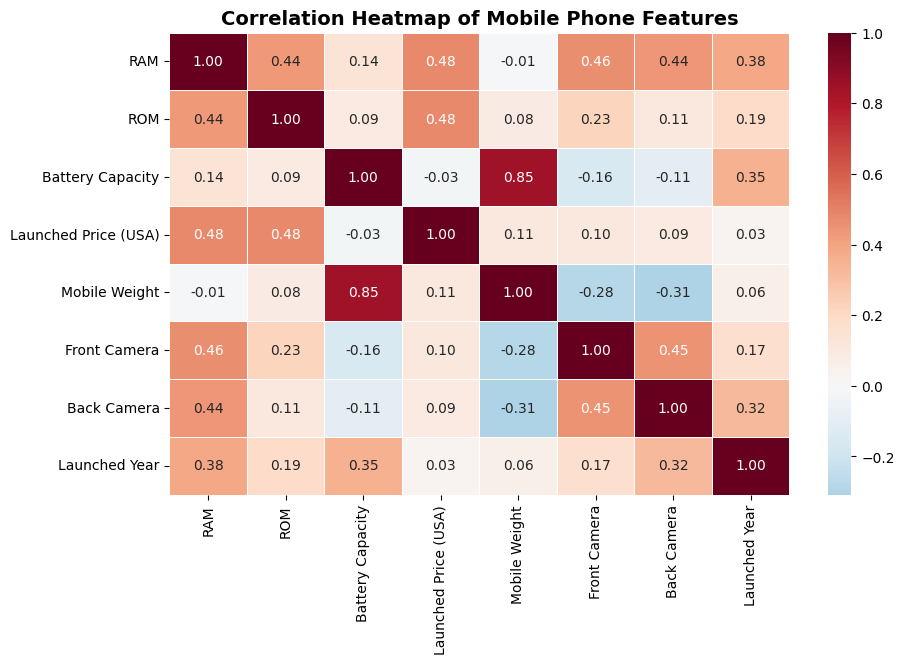

In [ ]:
# Select only numerical columns
numeric_data = data[['RAM', 'ROM', 'Battery Capacity', 'Launched Price (USA)',
                     'Mobile Weight', 'Front Camera', 'Back Camera', 'Launched Year' ]]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Mobile Phone Features", fontsize=14, fontweight="bold")
plt.show()


## Step 5: Train-Test Split

In [ ]:
print("Handling missing values...")

for col in ['RAM', 'Front Camera', 'Back Camera'
            , 'Battery Capacity', 'Screen Size']:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        print(f"  {col}: Filled {data[col].isnull().sum()} NaNs with median {median_val:.2f}")

# Remove rows with NaN in target variable
data = data.dropna(subset=['Launched Price (USA)'])

# Remove duplicates
initial_shape = data.shape[0]
data = data.drop_duplicates()
print(f"\n✅ Removed {initial_shape - data.shape[0]} duplicate rows")
print(f"\nFinal shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")

final_df = data.copy()

Handling missing values...
  Screen Size: Filled 0 NaNs with median 6.67

✅ Removed 15 duplicate rows

Final shape: (908, 21)
Missing values: 0


In [30]:
# insert data to Mobiles-Dataset-2025-processed.csv
data.to_csv('Mobiles-Dataset-2025-processed.csv', index=False)
print(data)

      RAM  Front Camera  Back Camera  Battery Capacity  Screen Size  \
0     6.0          12.0         48.0              3.60         6.10   
1     6.0          12.0         48.0              3.60         6.10   
2     6.0          12.0         48.0              3.60         6.10   
3     6.0          12.0         48.0              4.20         6.70   
4     6.0          12.0         48.0              4.20         6.70   
..    ...           ...          ...               ...          ...   
924   6.0           8.0         50.0              5.11         6.67   
925   8.0           8.0          8.0             10.00        12.10   
926   8.0           8.0          8.0             10.00        12.10   
927  12.0          10.0         50.0              4.40         7.60   
928  12.0          10.0         50.0              4.40         7.60   

     Launched Price (USA)    ROM  Company_Apple  Company_Honor  Company_Oppo  \
0                   799.0  0.125              1              0     

In [ ]:
# Drop rows where target variable is NaN
data = data.dropna(subset=['Launched Price (USA)'])

X = data.drop(['Launched Price (USA)', 'Model Name', 'Company Name', 'Processor'], axis=1)
y = data['Launched Price (USA)']
print(X)
X.to_csv('Mobiles-Dataset-2025-processed_V2.csv', index=False)

     Mobile Weight   RAM  Front Camera  Back Camera  Battery Capacity  \
0            174.0   6.0          12.0         48.0              3.60   
1            174.0   6.0          12.0         48.0              3.60   
2            174.0   6.0          12.0         48.0              3.60   
3            203.0   6.0          12.0         48.0              4.20   
4            203.0   6.0          12.0         48.0              4.20   
..             ...   ...           ...          ...               ...   
924          198.0   6.0           8.0         50.0              5.11   
925          571.0   8.0           8.0          8.0             10.00   
926          571.0   8.0           8.0          8.0             10.00   
927          239.0  12.0          10.0         50.0              4.40   
928          239.0  12.0          10.0         50.0              4.40   

     Screen Size  Launched Year    ROM  Company_Apple  Company_Honor  \
0           6.10           2024  0.125             

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X.shape, X_train.shape, X_train.shape)
print(X_train.isnull().sum())

(908, 17) (726, 17) (726, 17)
Mobile Weight       0
RAM                 0
Front Camera        0
Back Camera         0
Battery Capacity    0
Screen Size         0
Launched Year       0
ROM                 0
Company_Apple       0
Company_Honor       0
Company_Oppo        0
Company_Other       0
Company_Samsung     0
Company_Vivo        0
Processor_vec1      0
Processor_vec2      0
Processor_vec3      0
dtype: int64


## Step 7: Standardize Data for KNeighborsRegressor & LR

In [ ]:
# Standardized the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(np.isnan(X_train_scaled).sum())
print(np.isnan(X_test_scaled).sum())

0
0


## Step 8: Models Training and Evoluation

In [ ]:
models_scaled = {
    "Linear Regression": LinearRegression(),
    "knn_model": KNeighborsRegressor(n_neighbors=5)
}

for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"{name}:")
    print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", round(r2_score(y_test, y_pred) * 100, 2), '%')
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print("=" * 30)


Linear Regression:
RMSE: 249.95509484130451
R2 Score: 62.39 %
MAE:  179.127792967838
knn_model:
RMSE: 177.16786445522894
R2 Score: 81.11 %
MAE:  115.93572527472526


### ii.  Models That Do NOT Need Scaling:


In [ ]:
# Define models with tuned parameters
models_unscaled = {
    "Decision Tree": DecisionTreeRegressor(
        max_depth=20,
        min_samples_split=15,
        min_samples_leaf=8,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
}


# Train & evaluate each model once
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Regression metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2 Score: {r2:.2f} %")
    print("=" * 50)


Decision Tree:
  RMSE: 184.68
  MAE: 126.88
  R2 Score: 79.47 %
Random Forest:
  RMSE: 134.44
  MAE: 91.25
  R2 Score: 89.12 %


## Models Performance

In [ ]:
# Store results in a list
results = []

# Unscaled models
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Scaled models
for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2 Score (%)"])

# Sort by best R² score
results_df = results_df.sort_values(by="R2 Score (%)", ascending=False).reset_index(drop=True)

# Round values for readability
results_df["RMSE"] = results_df["RMSE"].round(2)
results_df["MAE"] = results_df["MAE"].round(2)
results_df["R2 Score (%)"] = results_df["R2 Score (%)"].round(2)

# Print as a clean professional table
print(tabulate(results_df, headers="keys", tablefmt="fancy_grid", showindex=False))


╒═══════════════════╤════════╤════════╤════════════════╕
│ Model             │   RMSE │    MAE │   R2 Score (%) │
╞═══════════════════╪════════╪════════╪════════════════╡
│ Random Forest     │ 134.44 │  91.25 │          89.12 │
├───────────────────┼────────┼────────┼────────────────┤
│ knn_model         │ 177.17 │ 115.94 │          81.11 │
├───────────────────┼────────┼────────┼────────────────┤
│ Decision Tree     │ 184.68 │ 126.88 │          79.47 │
├───────────────────┼────────┼────────┼────────────────┤
│ Linear Regression │ 249.96 │ 179.13 │          62.39 │
╘═══════════════════╧════════╧════════╧════════════════╛
